In [1]:
pip install rasterio matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import sklearn
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Data for 2015 tree information
data_tree = pd.read_csv("/content/drive/My Drive/Ds301_Project/2015StreetTreesCensus_TREES.csv")

#Data for aricondition utility in 2020
data_aircondition=pd.read_csv("/content/drive/My Drive/Ds301_Project/NYC EH Data Portal - Household air conditioning (full).csv")

#Data for housing information by block in 2020
data_housing=pd.read_csv("/content/drive/My Drive/Ds301_Project/Housing_Database_by_2020_Census_Block_20240430.csv")

#Data for specific block with high temperature in 2020
data_specifhigh=pd.read_csv("/content/drive/My Drive/Ds301_Project/Hyperlocal_Temperature_Monitoring_20240430.csv")

#Data for housing emission in 2020
data_emission=pd.read_csv("/content/drive/My Drive/Ds301_Project/NYC_Municipal_Building_Energy_Benchmarking_Results_20240430.csv")

#Data for water and energy consumption in privately owned buildings in 2020
dara_energy=pd.read_csv("/content/drive/MyDrive/Ds301_Project/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013__Data_for_Calendar_Year_2012__20240501.csv")

<ipython-input-4-691eb7a86fc5>:17: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dara_energy=pd.read_csv("/content/drive/MyDrive/Ds301_Project/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013__Data_for_Calendar_Year_2012__20240501.csv")


In [5]:
data_aircondition

,Time,GeoType,GeoID,GeoRank,Geography,Number (with AC),Percent (with AC)
0,2017,Subboro,1,5,Mott Haven/Hunts Point,"40,000.0","84.3 (79.1, 89.5)"
1,2017,Subboro,2,5,Morrisania/East Tremont,"37,000.0","75.8 (69.0, 82.5)"
2,2017,Subboro,3,5,Highbridge/South Concourse,"35,000.0","84.6 (77.7, 91.6)"
3,2017,Subboro,4,5,University Heights/Fordham,"33,000.0","79.7 (73.4, 86.0)"
4,2017,Subboro,5,5,Kingsbridge Heights/Mosholu,"41,000.0","87.3 (81.1, 93.4)"
...,...,...,...,...,...,...,...
117,2014,Borough,2,1,Brooklyn,"773,000.0","84.8 (83.7, 86)"
118,2014,Borough,3,1,Manhattan,"685,000.0","92.7 (91.7, 93.7)"
119,2014,Borough,4,1,Queens,"711,000.0","92.0 (91.1, 92.9)"
120,2014,Borough,5,1,Staten Island,"151,000.0","93.7 (91.7, 95.7)"


Metadata for the TIFF file:
Width: 2061, Height: 1556
Number of bands: 1
Coordinate Reference System: EPSG:4326
Transform: | 0.00, 0.00,-74.26|
| 0.00,-0.00, 40.92|
| 0.00, 0.00, 1.00|



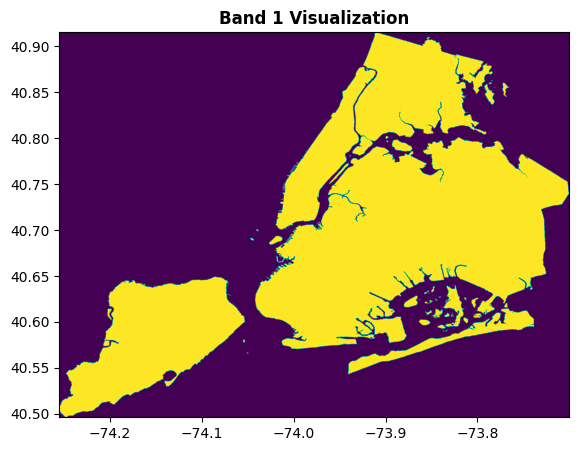

In [6]:
#Data for surface temperature in 2020
# Open the TIFF file
with rasterio.open('/content/drive/MyDrive/Ds301_Project/f_mean_temp.tif') as src:
    # Read metadata
    print("Metadata for the TIFF file:")
    print(f"Width: {src.width}, Height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System: {src.crs}")
    print(f"Transform: {src.transform}\n")

    # Read the first band
    band1 = src.read(1)

    # Plot the first band
    plt.figure(figsize=(10, 5))
    show(band1, transform=src.transform, title="Band 1 Visualization")
    plt.show()

In [7]:
#covert to csv data
with rasterio.open('/content/drive/MyDrive/Ds301_Project/f_mean_temp.tif') as src:
# Read the data
    data = src.read(1)  # Read the first band

    # Get coordinates for each pixel
    # Transform (col, row) to (x, y) - coordinate pairs for the center of each pixel
    cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)

    # Flatten the arrays
    xs = np.array(xs).flatten()
    ys = np.array(ys).flatten()
    data = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'Longitude': xs,
        'Latitude': ys,
        'Value': data
    })

    # Remove any rows where data might be a nodata value
    df = df[df['Value'] != src.nodata]

# Save to CSV
df.to_csv('output_data.csv', index=False)
data_surfacetemp = pd.read_csv("output_data.csv")
data_surfacetemp

,Longitude,Latitude,Value
0,-73.910372,40.915342,54.382530
1,-73.910372,40.915072,53.922497
2,-73.910103,40.915072,56.125908
3,-73.909833,40.915072,57.034510
4,-73.909564,40.915072,58.681686
...,...,...,...
1141808,-74.247779,40.496278,51.534393
1141809,-74.247510,40.496278,52.097195
1141810,-74.247240,40.496278,52.681380
1141811,-74.246971,40.496278,52.143604


# Tree

In [8]:
data_tree['longitude'] = data_tree['longitude'].round(decimals=4)
data_tree['Latitude'] = data_tree['Latitude'].round(decimals=4)

data_surfacetemp['Longitude'] = data_surfacetemp['Longitude'].round(decimals=4)
data_surfacetemp['Latitude'] = data_surfacetemp['Latitude'].round(decimals=4)

In [9]:
grouped_data = data_surfacetemp.groupby(['Longitude', 'Latitude'])['Value'].mean().reset_index()
grouped_data

,Longitude,Latitude,Value
0,-74.2553,40.5044,48.628895
1,-74.2553,40.5046,48.922490
2,-74.2553,40.5049,49.157513
3,-74.2553,40.5052,49.396473
4,-74.2553,40.5054,50.527260
...,...,...,...
1141808,-73.7004,40.7421,73.035400
1141809,-73.7002,40.7394,75.240410
1141810,-73.7002,40.7396,75.348915
1141811,-73.7002,40.7399,74.533714


In [10]:
#Investigate the relationship between tree and surface area
# Load tree data
tree_geometry = [Point(xy) for xy in zip(data_tree['longitude'], data_tree['Latitude'])]
geo_tree = gpd.GeoDataFrame(data_tree, geometry=tree_geometry, crs="EPSG:4326")

# Load surface temperature data
temp_geometry = [Point(xy) for xy in zip(grouped_data['Longitude'], grouped_data['Latitude'])]
geo_temp = gpd.GeoDataFrame(grouped_data, geometry=temp_geometry, crs="EPSG:4326")

# Spatial join - nearest temperature to each tree
tree_with_temp = gpd.sjoin_nearest(geo_tree, geo_temp, how="left", max_distance=None)

# Aggregate temperature and tree count by neighborhood
agg_temp = tree_with_temp.dissolve(by='nta_name', aggfunc={'Value': 'mean'})
agg_trees = tree_with_temp.dissolve(by='nta_name', aggfunc='count')

# Merge the aggregated data
combined_data = pd.merge(agg_temp, agg_trees, on='nta_name')

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
# Calculate Pearson correlation coefficient
correlation_coef, _ = pearsonr(combined_data['Value_x'], combined_data['tree_id'])  # Replace 'tree_id' with count of trees
print("Pearson Correlation Coefficient:", correlation_coef)

Pearson Correlation Coefficient: 0.22947654288463992


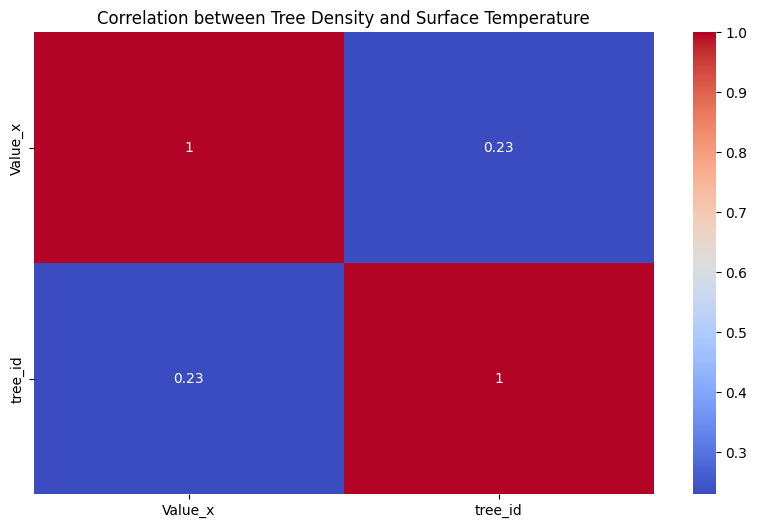

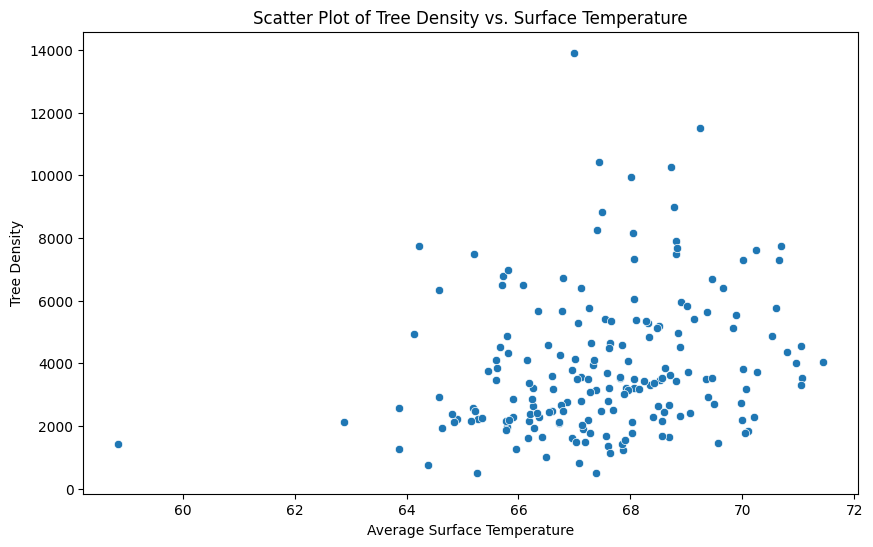

In [12]:
# Heatmap of tree density and average temperature
plt.figure(figsize=(10, 6))
sns.heatmap(combined_data[['Value_x', 'tree_id']].corr(), annot=True, cmap='coolwarm')  # Adjust as necessary
plt.title('Correlation between Tree Density and Surface Temperature')
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_data, x='Value_x', y='tree_id')
plt.title('Scatter Plot of Tree Density vs. Surface Temperature')
plt.xlabel('Average Surface Temperature')
plt.ylabel('Tree Density')
plt.show()

In [13]:
pip install xgboost

In [14]:
combined_data

,geometry_x,Value_x,geometry_y,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,...,boro_ct,state,Latitude_left,longitude,x_sp,y_sp,index_right,Longitude,Latitude_right,Value_y
nta_name,,,,,,,,,,,,,,,,,,,,,
Allerton-Pelham Gardens,"MULTIPOINT (-73.86140 40.86600, -73.86140 40.8...",66.158369,"MULTIPOINT (-73.86140 40.86600, -73.86140 40.8...",4112,4112,4112,4112,4112,4112,4112,...,4112,4112,4112,4112,4112,4112,4112,4112,4112,4112
Annadale-Huguenot-Prince's Bay-Eltingville,"MULTIPOINT (-74.21360 40.52100, -74.21360 40.5...",66.989106,"MULTIPOINT (-74.21360 40.52100, -74.21360 40.5...",13916,13916,13916,13916,13916,13916,13916,...,13916,13916,13916,13916,13916,13916,13916,13916,13916,13916
Arden Heights,"MULTIPOINT (-74.20300 40.55530, -74.20300 40.5...",68.816986,"MULTIPOINT (-74.20300 40.55530, -74.20300 40.5...",7503,7503,7503,7503,7503,7503,7503,...,7503,7503,7503,7503,7503,7503,7503,7503,7503,7503
Astoria,"MULTIPOINT (-73.93830 40.76680, -73.93820 40.7...",67.637685,"MULTIPOINT (-73.93830 40.76680, -73.93820 40.7...",4633,4633,4633,4633,4633,4633,4633,...,4633,4633,4633,4633,4633,4633,4633,4633,4633,4633
Auburndale,"MULTIPOINT (-73.79720 40.74070, -73.79720 40.7...",69.359471,"MULTIPOINT (-73.79720 40.74070, -73.79720 40.7...",5646,5646,5646,5646,5646,5646,5646,...,5646,5646,5646,5646,5646,5646,5646,5646,5646,5646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Windsor Terrace,"MULTIPOINT (-73.98760 40.65960, -73.98730 40.6...",65.222340,"MULTIPOINT (-73.98760 40.65960, -73.98730 40.6...",2467,2467,2467,2467,2467,2467,2467,...,2467,2467,2467,2467,2467,2467,2467,2467,2467,2467
Woodhaven,"MULTIPOINT (-73.87500 40.68890, -73.87490 40.6...",67.617954,"MULTIPOINT (-73.87500 40.68890, -73.87490 40.6...",4481,4481,4481,4481,4481,4481,4481,...,4481,4481,4481,4481,4481,4481,4481,4481,4481,4481
Woodlawn-Wakefield,"MULTIPOINT (-73.87720 40.89570, -73.87710 40.8...",65.812629,"MULTIPOINT (-73.87720 40.89570, -73.87710 40.8...",4339,4339,4339,4339,4339,4339,4339,...,4339,4339,4339,4339,4339,4339,4339,4339,4339,4339


In [15]:
print(combined_data.columns)

Index(['geometry_x', 'Value_x', 'geometry_y', 'created_at', 'tree_id',
       'block_id', 'the_geom', 'tree_dbh', 'stump_diam', 'curb_loc', 'status',
       'health', 'spc_latin', 'spc_common', 'steward', 'guards', 'sidewalk',
       'user_type', 'problems', 'root_stone', 'root_grate', 'root_other',
       'trnk_wire', 'trnk_light', 'trnk_other', 'brnch_ligh', 'brnch_shoe',
       'brnch_othe', 'address', 'zipcode', 'zip_city', 'cb_num', 'borocode',
       'boroname', 'cncldist', 'st_assem', 'st_senate', 'nta', 'boro_ct',
       'state', 'Latitude_left', 'longitude', 'x_sp', 'y_sp', 'index_right',
       'Longitude', 'Latitude_right', 'Value_y'],
      dtype='object')


In [16]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# XG Boost
X = combined_data[['tree_id']]
y = combined_data['Value_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost regressor object
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predicting the Test set results
y_pred = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 1.4649764714297107


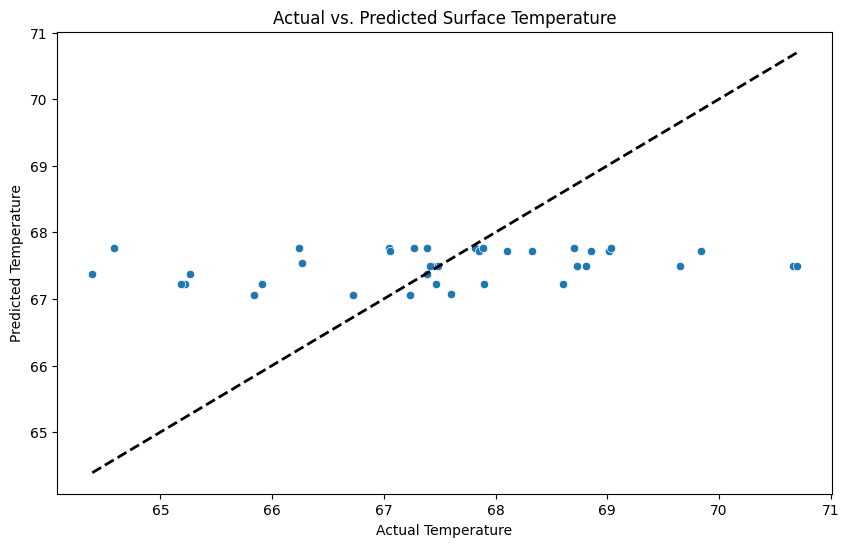

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Actual vs. Predicted Surface Temperature')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.show()

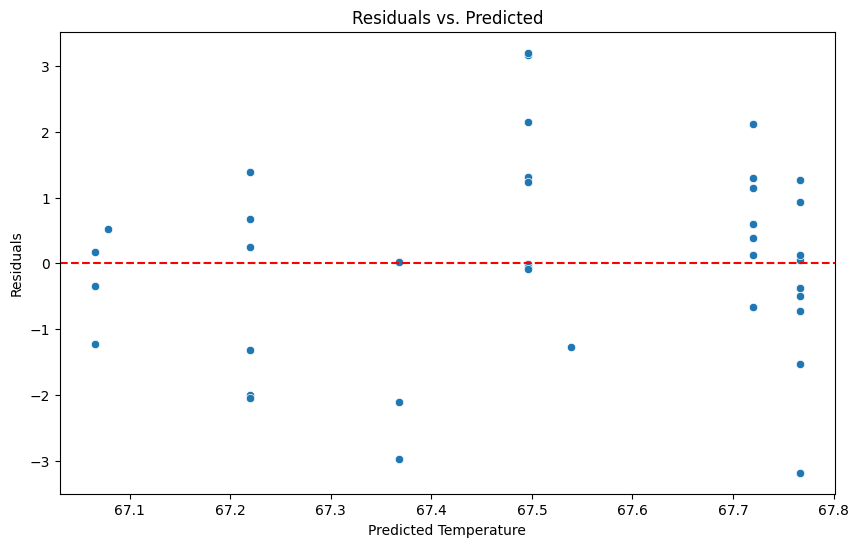

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Temperature')
plt.ylabel('Residuals')
plt.show()

# Emission

In [19]:
data_emission

,Borough,Block,Lot,BIN,Building,Agency,2010 Rating *,2010 Source EUI (kBtu/sq.ft.),2010 GHG Emissions Intensity (kgCO2e/ft²) †,2011 Rating *,2011 Source EUI (kBtu/sq.ft.),2011 GHG Emissions Intensity (kgCO2e/ft²) †,2012 Rating *,2012 Source EUI (kBtu/sq.ft.),2012 GHG Emissions Intensity (kgCO2e/ft²) †,2013 Rating *,2013 Source EUI (kBtu/sq.ft.),2013 GHG Emissions Intensity (kgCO2e/ft²) †,EPAPMBenchmarkedAs,Campus Name
0,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,155.9,4.3,NaN,157.7,4.3,NaN,164.8,4.5,Individual building,NaN
1,1,93,1,1062652,ACS Administrative Site,ACS,57,239.0,6.2,55,242.1,6.3,59,228.3,5.9,64.0,217.9,5.6,Individual building,NaN
2,3,4484,13,3098733,ACS Administrative Site,ACS,16,286.6,8.6,19,268.3,7.9,20,258.6,7.6,24.0,252.1,7.5,Space within building,NaN
3,2,4101,1,2044743,ACS Bronx Field Office,ACS,7,316.2,8.9,14,269.6,7.2,12,273.0,7.4,12.0,282.8,7.9,Individual building,NaN
4,3,2022,18,3057913,Administration Site,ACS,21,313.6,9.8,31,272.4,8.4,35,257.9,7.5,37.0,256.1,7.6,Individual building,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,4,4717,25,4107201,Whitestone Community Library,QPL,N/A,460.1,13.6,NaN,400.3,12.3,NaN,414.6,12.4,NaN,309.1,9.8,Individual building,NaN
3384,4,7772,1,4164306,Windsor Park Community Library,QPL,N/A,107.3,3.7,NaN,255.1,8.1,NaN,250.1,7.4,NaN,281.7,8.5,Individual building,NaN
3385,4,8856,85,4181578,Woodhaven Community Library,QPL,N/A,321.2,10.9,NaN,336.8,11.8,NaN,283.5,9.5,NaN,247.0,8.1,Individual building,NaN
3386,4,1317,85,4030847,Woodside Community Library,QPL,N/A,379.9,13.6,NaN,287.8,9.7,NaN,431.9,16.1,NaN,296.2,10.1,Individual building,NaN


In [20]:
pluto_data = pd.read_csv('/content/drive/MyDrive/Ds301_Project/Primary_Land_Use_Tax_Lot_Output__PLUTO__20240430.csv')
pluto_data.head()
data_emission.rename(columns={'Block': 'block'}, inplace=True)
data_emission.rename(columns={'Borough': 'borough'}, inplace=True)


data_emission['block'] = data_emission['block'].astype(str)
data_emission['borough'] = data_emission['borough'].astype(str)


pluto_data['block'] = pluto_data['block'].astype(str)
pluto_data['borough'] = pluto_data['borough'].astype(str)


merged_data = pd.merge(data_emission, pluto_data, on=['block'])

<ipython-input-20-0325c3ee38a8>:1: DtypeWarning: Columns (17,18,20,21,22,24,25,52,61,62,79,97) have mixed types. Specify dtype option on import or set low_memory=False.
  pluto_data = pd.read_csv('/content/drive/MyDrive/Ds301_Project/Primary_Land_Use_Tax_Lot_Output__PLUTO__20240430.csv')


In [21]:
merged_data

,borough_x,block,Lot,BIN,Building,Agency,2010 Rating *,2010 Source EUI (kBtu/sq.ft.),2010 GHG Emissions Intensity (kgCO2e/ft²) †,2011 Rating *,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10
1,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10
2,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10
3,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10
4,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252612,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3013900.0,3.013900e+10
252613,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10
252614,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10
252615,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10


In [22]:
#Calculate the mean emission
columns = [
    '2010 GHG Emissions Intensity (kgCO2e/ft²) †',
    '2011 GHG Emissions Intensity (kgCO2e/ft²) †',
    '2012 GHG Emissions Intensity (kgCO2e/ft²) †',
    '2013 GHG Emissions Intensity (kgCO2e/ft²) †'
]

# Convert columns to numeric, coercing errors to NaN
for col in columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Now calculate the mean emission
merged_data['Mean_emission'] = merged_data[columns].mean(axis=1)

In [23]:
merged_data

,borough_x,block,Lot,BIN,Building,Agency,2010 Rating *,2010 Source EUI (kBtu/sq.ft.),2010 GHG Emissions Intensity (kgCO2e/ft²) †,2011 Rating *,...,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020,Mean_emission
0,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10,4.50
1,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10,4.50
2,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10,4.50
3,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10,4.50
4,2,2383,12,2001505,1332 Fulton Ave D C C Inc,ACS,N/A,180.6,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5027706.0,5.027706e+10,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252612,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3013900.0,3.013900e+10,3.05
252613,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10,3.05
252614,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10,3.05
252615,4,1016,45,4022499,TLC Inspections Facility,TLC,N/A,92.1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4029900.0,4.029900e+10,3.05


In [24]:
merged_data['longitude'] = merged_data['longitude'].round(decimals=4)
merged_data['latitude'] = merged_data['latitude'].round(decimals=4)

#Investigate the relationship between tree and surface area
# Load emission data
# Create geometry for emissions data
emission_geometry = [Point(xy) for xy in zip(merged_data['longitude'], merged_data['latitude'])]
geo_emissions = gpd.GeoDataFrame(merged_data, geometry=emission_geometry, crs="EPSG:4326")

# Create geometry for surface temperature data
temp_geometry = [Point(xy) for xy in zip(data_surfacetemp['Longitude'], data_surfacetemp['Latitude'])]
geo_temp = gpd.GeoDataFrame(data_surfacetemp, geometry=temp_geometry, crs="EPSG:4326")

# Perform a spatial join - to find the nearest surface temperature for each emission data point
emissions_with_temp = gpd.sjoin_nearest(geo_emissions, geo_temp, how="left", max_distance=30)


# Aggregate emissions data and average temperature by some geographical identifier (e.g., 'block' in emissions data)
agg_emissions = emissions_with_temp.dissolve(by='block', aggfunc={'Mean_emission': 'mean'})
agg_temperature = emissions_with_temp.dissolve(by='block', aggfunc={'Value': 'mean'})

# Merge the aggregated data on block
combined_data = pd.merge(agg_emissions, agg_temperature, on='block')

print(combined_data)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


                                              geometry_x  Mean_emission  \
block                                                                     
1      MULTIPOINT (-74.07550 40.63810, -74.07550 40.6...     129.000000   
100    MULTIPOINT (-74.09800 40.63450, -74.09790 40.6...       5.233333   
1000   MULTIPOINT (-73.98410 40.75920, -73.98400 40.7...       4.225000   
10021  MULTIPOINT (-73.80790 40.69450, -73.80790 40.6...       3.850000   
10024  MULTIPOINT (-73.80680 40.69490, -73.80620 40.6...       5.775000   
...                                                  ...            ...   
9919   MULTIPOINT (-73.77970 40.71280, -73.77950 40.7...       3.000000   
993    MULTIPOINT (-73.98750 40.75480, -73.98750 40.7...       8.700000   
998    MULTIPOINT (-73.98760 40.67090, -73.98760 40.6...       6.087500   
9993   MULTIPOINT (-73.80830 40.69830, -73.80770 40.6...       3.600000   
99999                                               None       2.652632   

                        

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Correlation Matrix:
               Mean_emission     Value
Mean_emission       1.000000 -0.059346
Value              -0.059346  1.000000


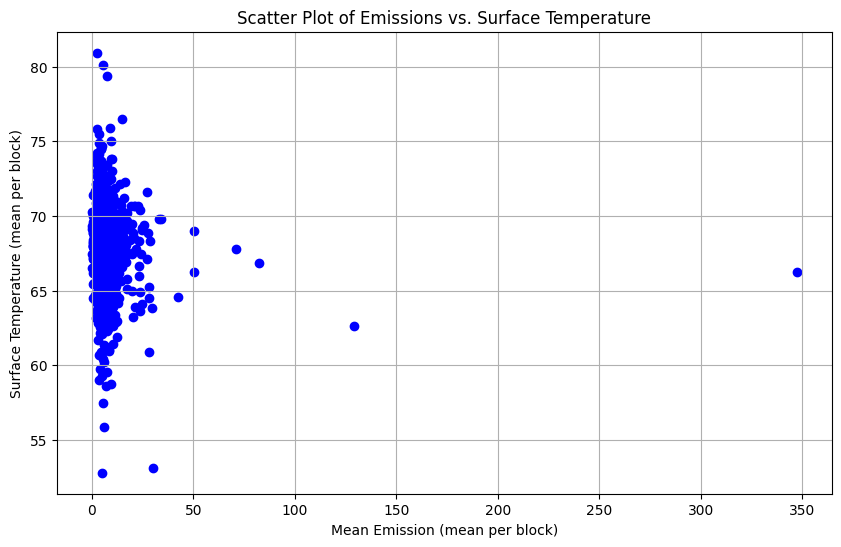

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


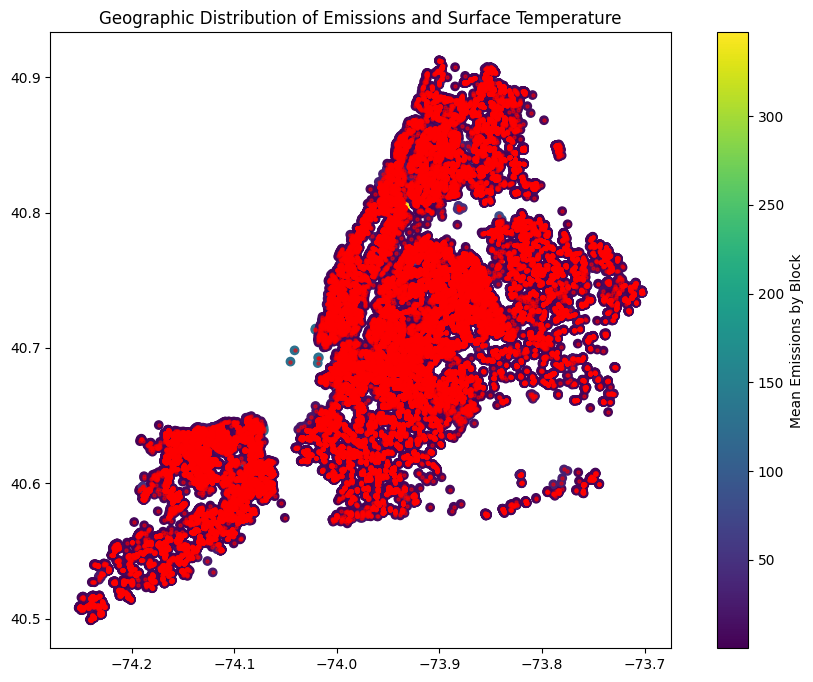

In [25]:
# Calculate Pearson correlation
correlation = combined_data[['Mean_emission', 'Value']].corr(method='pearson')
print("Correlation Matrix:")
print(correlation)

# Visualization: Scatter plot of emissions vs temperature
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Mean_emission'], combined_data['Value'], color='blue')
plt.title('Scatter Plot of Emissions vs. Surface Temperature')
plt.xlabel('Mean Emission (mean per block)')
plt.ylabel('Surface Temperature (mean per block)')
plt.grid(True)
plt.show()

# Visualization: Geographic plot of the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
agg_emissions.plot(column='Mean_emission', ax=ax, legend=True, legend_kwds={'label': "Mean Emissions by Block"})
agg_temperature.plot(column='Value', ax=ax, color='red', markersize=5, alpha=0.5)
plt.title('Geographic Distribution of Emissions and Surface Temperature')
plt.show()

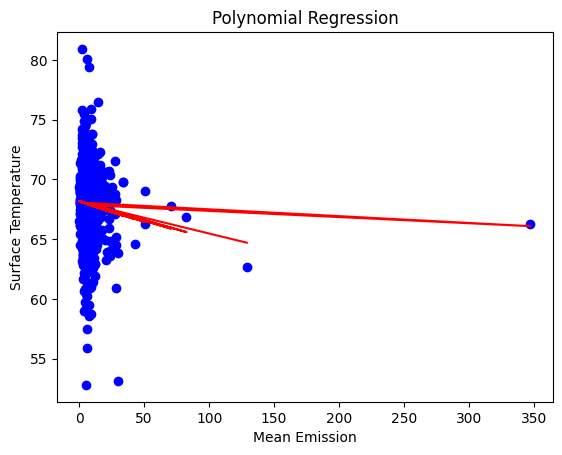

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression# Assuming 'combined_data' DataFrame with 'Mean_emission' as independent and 'Value' as dependent variable
cleaned_data = combined_data.dropna(subset=['Mean_emission', 'Value'])
X = cleaned_data['Mean_emission'].values.reshape(-1, 1)
y = cleaned_data['Value'].values

# Transforming data to include polynomial terms
poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree based on your data
X_poly = poly_features.fit_transform(X)

# Fitting the Polynomial Regression Model
model = LinearRegression()
model.fit(X_poly, y)

# Predicting values
y_pred = model.predict(X_poly)

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')
plt.title('Polynomial Regression')
plt.xlabel('Mean Emission')
plt.ylabel('Surface Temperature')
plt.show()

<ipython-input-28-ef673a59ccdb>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X), max(X), 0.01).reshape(-1, 1)


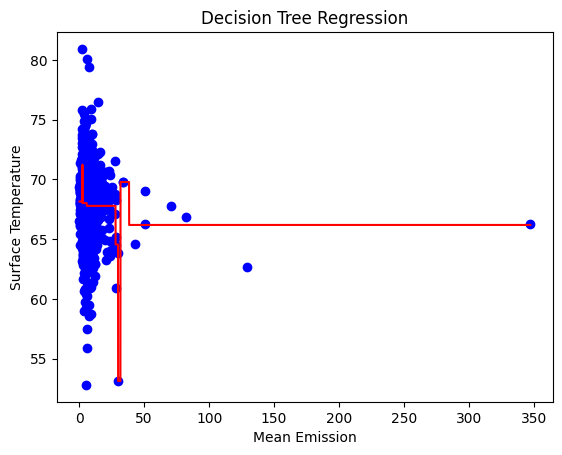

In [28]:
from sklearn.tree import DecisionTreeRegressor
# Fitting the Decision Tree Regression Model
tree_reg = DecisionTreeRegressor(max_depth=3)  # Adjust max_depth for complexity
tree_reg.fit(X, y)

# Predicting values across a range for visualization
X_grid = np.arange(min(X), max(X), 0.01).reshape(-1, 1)
y_pred = tree_reg.predict(X_grid)

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X_grid, y_pred, color='red')
plt.title('Decision Tree Regression')
plt.xlabel('Mean Emission')
plt.ylabel('Surface Temperature')
plt.show()

<ipython-input-29-b727ff121280>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X), max(X), 0.01).reshape(-1, 1)


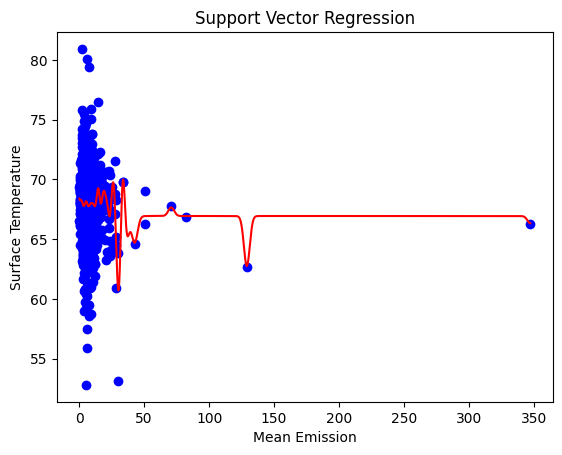

In [29]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(X, y)

# Predicting values across a range for visualization
X_grid = np.arange(min(X), max(X), 0.01).reshape(-1, 1)
y_pred = svr_rbf.predict(X_grid)

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X_grid, y_pred, color='red')
plt.title('Support Vector Regression')
plt.xlabel('Mean Emission')
plt.ylabel('Surface Temperature')
plt.show()

# Energy_tree regressor

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Ds301_Project/data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)


(array([5.000e+00, 4.700e+01, 5.640e+02, 3.485e+03, 6.990e+03, 1.964e+03,
        2.650e+02, 3.900e+01, 4.000e+00, 1.000e+00]),
 array([46.990993 , 51.5072667, 56.0235404, 60.5398141, 65.0560878,
        69.5723615, 74.0886352, 78.6049089, 83.1211826, 87.6374563,
        92.15373  ]),
 <BarContainer object of 10 artists>)

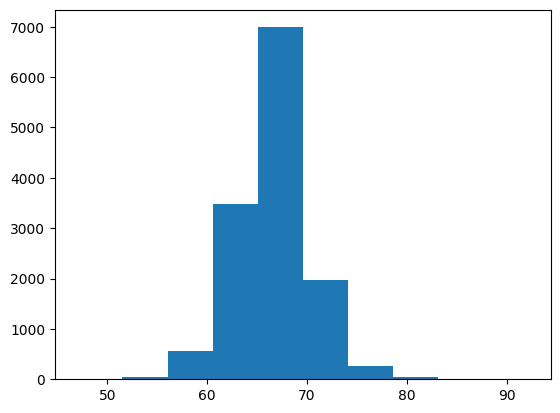

In [ ]:
plt.hist(df['Value'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7c44237e3070>,
 'caps': [<matplotlib.lines.Line2D at 0x7c44237e35b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c44237e2dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c44237e3af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c44237e3d90>],
 'means': []}

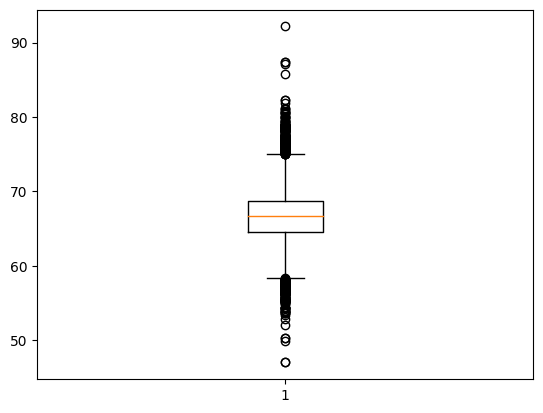

In [ ]:
plt.boxplot(df['Value'])

In [ ]:
def fill_outlier(x):
    mu = np.mean(x)
    std = np.std(x)
    condition_list = [x >= mu + 2.5 * std, x <= mu - 2.5 * std]
    choice_list = [mu + 2.5 * std, mu - 2.5 * std]
    x_trans = np.select(condlist=condition_list, choicelist=choice_list, default=x)
    return x_trans

In [ ]:
df['Value_trans'] = fill_outlier(df['Value'])

<ipython-input-9-b8753e70f155>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'corr', y = 'feat', data=df_corr, palette="coolwarm")


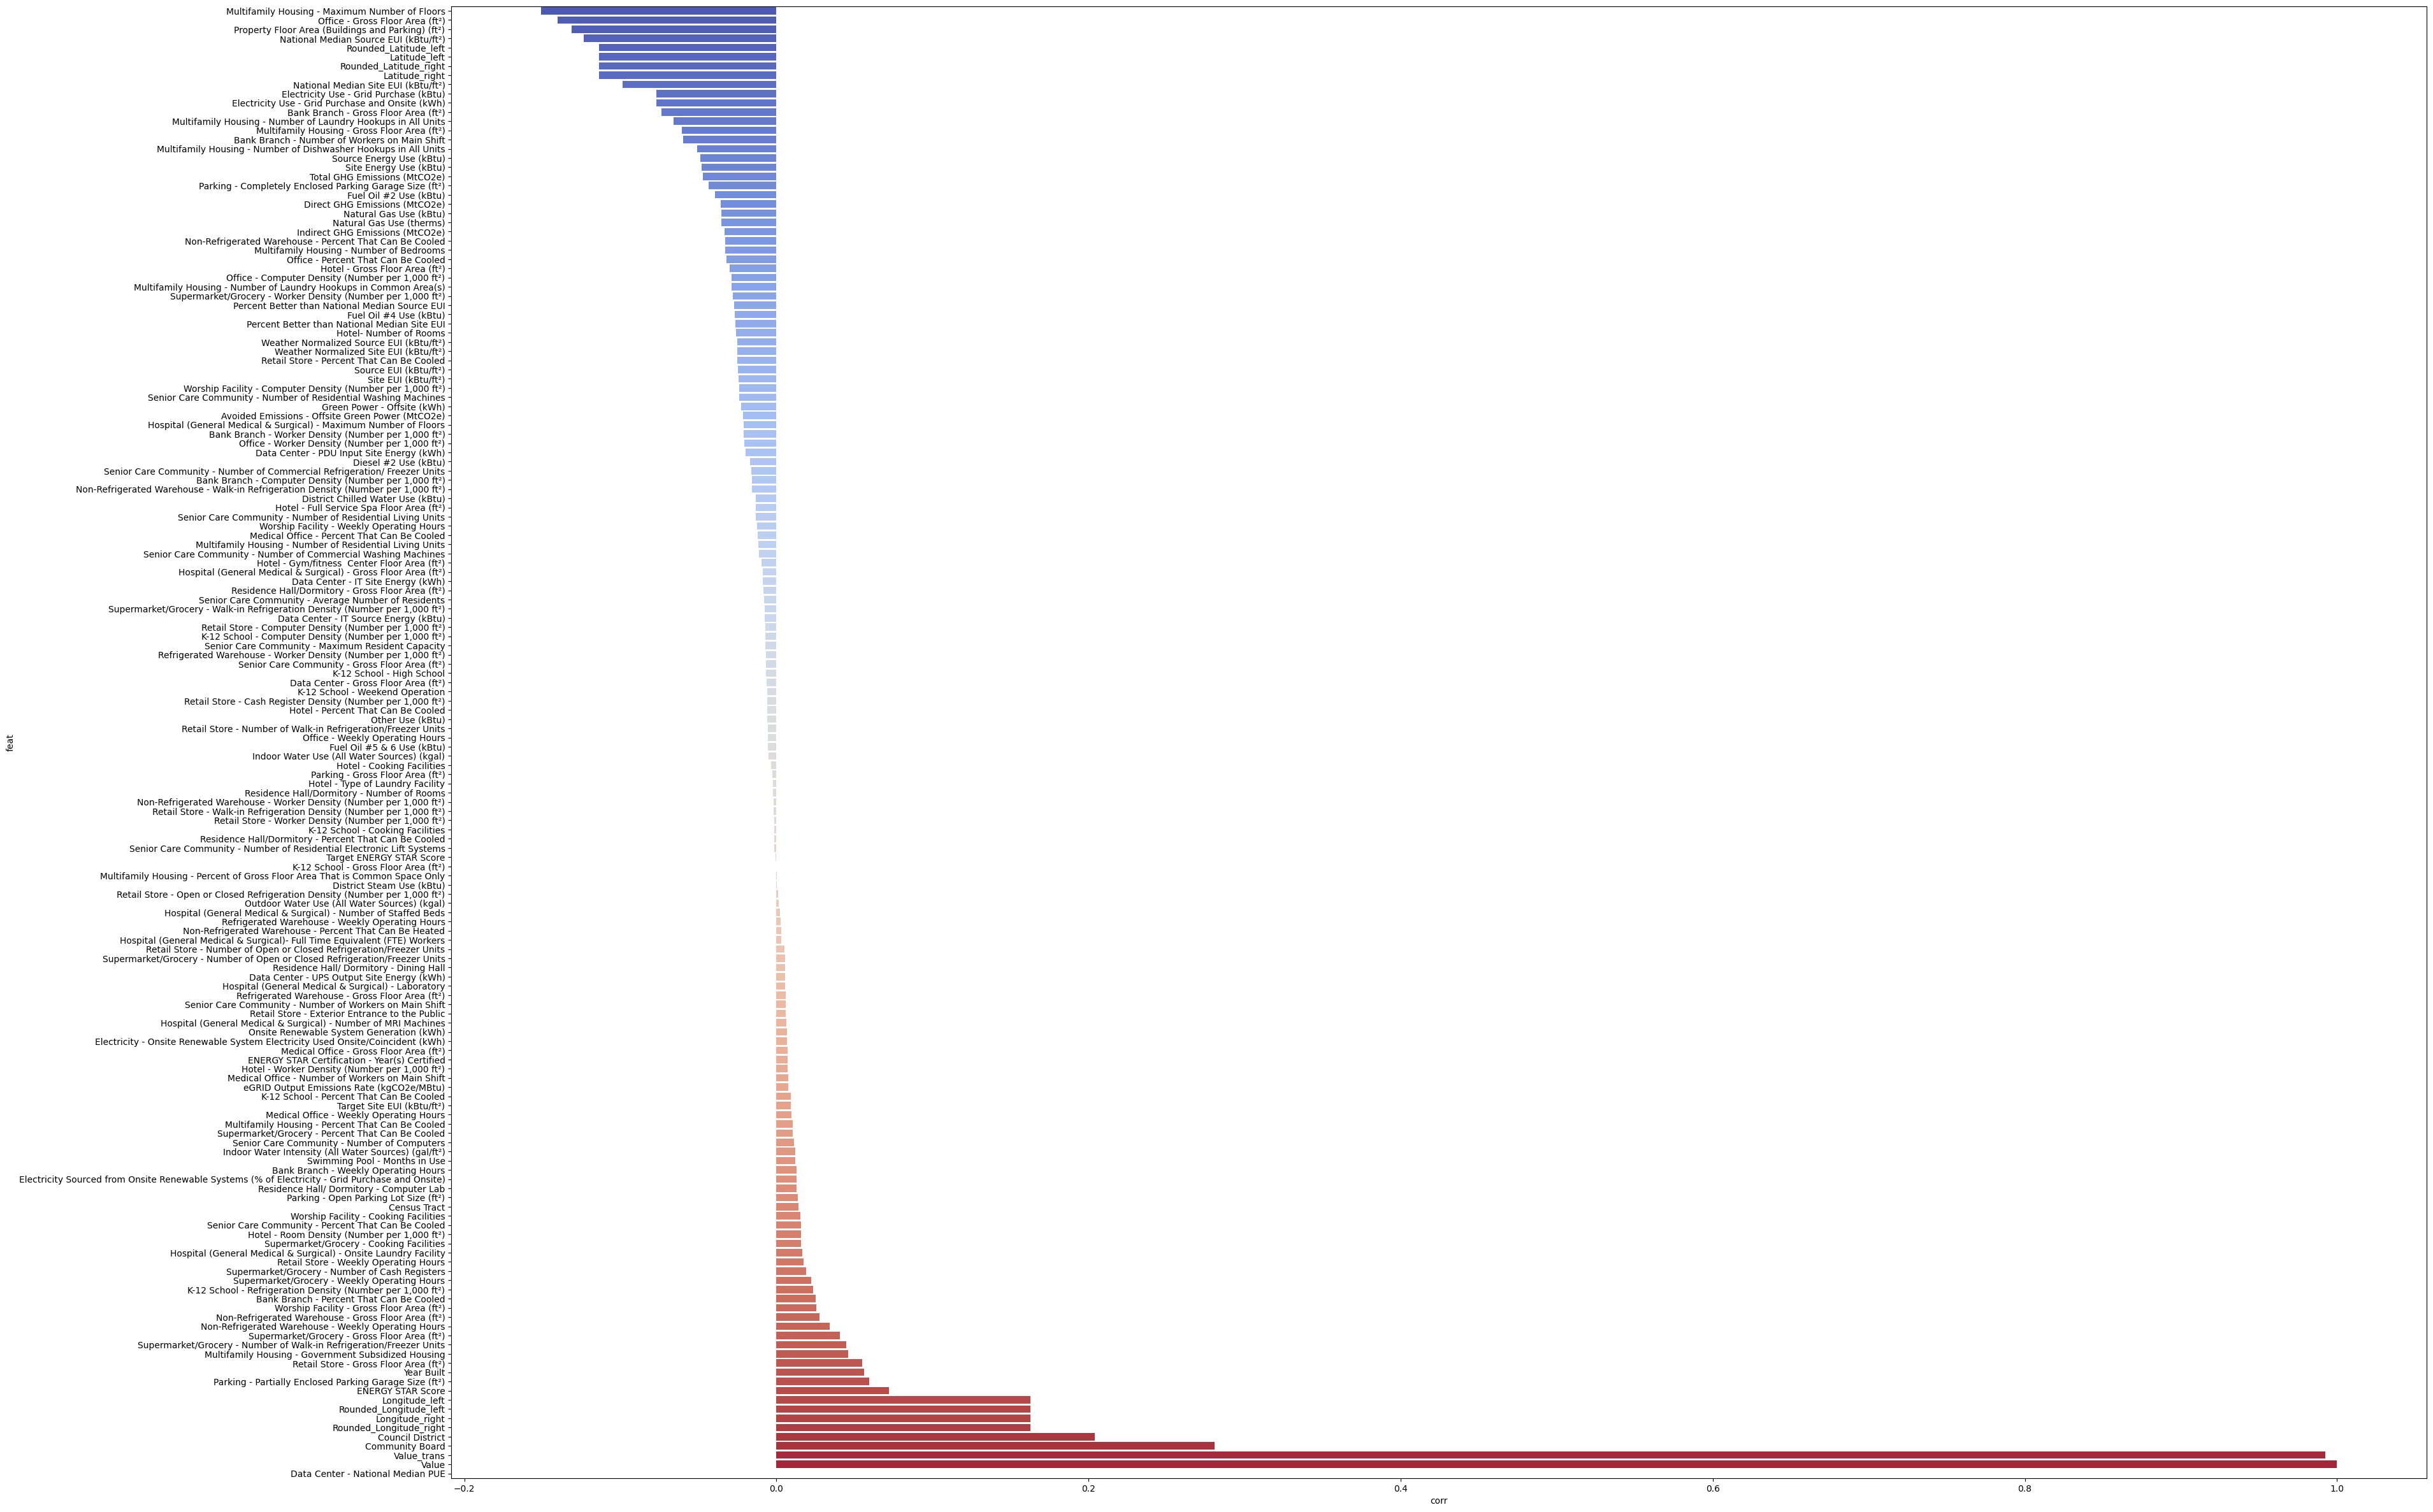

In [ ]:
# Feature
df_corr = pd.DataFrame(df.corr()['Value']).reset_index().rename(columns={'index': 'feat', 'Value': 'corr'})
df_corr.sort_values('corr', inplace=True)
plt.figure(figsize=(40,30))
sns.barplot(x = 'corr', y = 'feat', data=df_corr, palette="coolwarm")
plt.savefig('a.png', dpi=300)
plt.show()

In [ ]:
select_col = list(pd.DataFrame(abs(df.corr()['Value'])).reset_index().query('Value > 0.1')['index'])
print(select_col)
select_col_remove = [i for i in select_col if i.startswith("Round")]
select_col_new = list(set(select_col) - set(select_col_remove))
select_col_new.remove('Value')
select_col_new.remove('Value_trans')
select_col_new.remove('Community Board')
print(select_col_new )

['Property Floor Area (Buildings and Parking) (ft²)', 'National Median Source EUI (kBtu/ft²)', 'Multifamily Housing - Maximum Number of Floors', 'Office - Gross Floor Area (ft²)', 'Latitude_left', 'Longitude_left', 'Community Board', 'Council District', 'Rounded_Longitude_left', 'Rounded_Latitude_left', 'Longitude_right', 'Latitude_right', 'Value', 'Rounded_Longitude_right', 'Rounded_Latitude_right', 'Value_trans']
['National Median Source EUI (kBtu/ft²)', 'Office - Gross Floor Area (ft²)', 'Council District', 'Multifamily Housing - Maximum Number of Floors', 'Longitude_right', 'Longitude_left', 'Latitude_left', 'Latitude_right', 'Property Floor Area (Buildings and Parking) (ft²)']


In [ ]:
# Train the tree regressor
from sklearn.preprocessing import OneHotEncoder
onehot_lbe = OneHotEncoder()
onehot = onehot_lbe.fit_transform(df[['Community Board']])
y=df['Value']
predictor=df[select_col_new]
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
predictor_new = scaler.fit_transform(predictor)
X = np.hstack((predictor_new, onehot.toarray()))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, auc
import numpy as np

model_perceptron = DecisionTreeRegressor()
# fit the model
model_perceptron.fit(X_train, y_train)

# Calculate the median or another threshold that makes sense for your scenario
threshold = np.median(y_train)



perceptron_y_pred = model_perceptron.predict(X_test)

r2 =r2_score(y_test, perceptron_y_pred)
MSE = mean_squared_error(y_test, perceptron_y_pred)
# roc_auc = roc_auc_score(y_test, perceptron_y_pred)

#Print them
print(f"MSE: {MSE:.4f}")
print(f"r2: {r2:.4f}")

MSE: 7.1200
r2: 0.4405


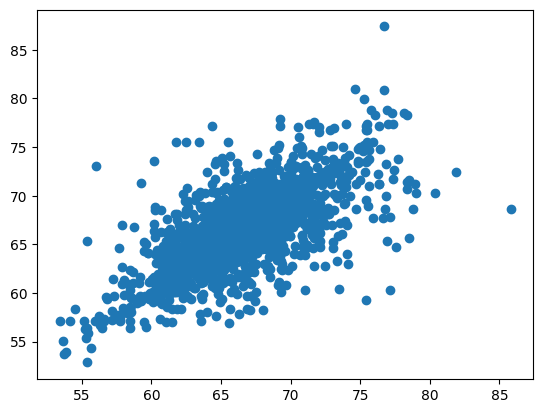

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test, perceptron_y_pred)

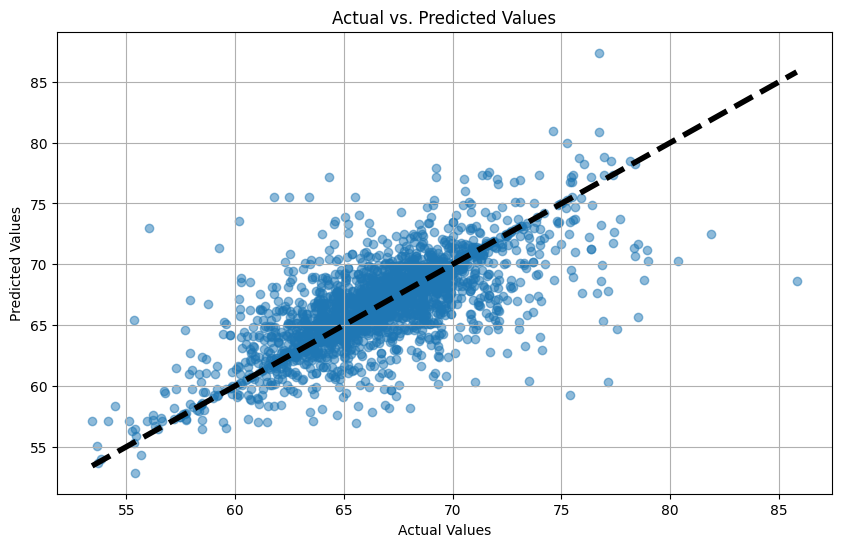

In [ ]:
# Predicting values using the DecisionTreeRegressor
perceptron_y_pred = model_perceptron.predict(X_test)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, perceptron_y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line showing perfect predictions
plt.grid(True)
plt.show()

# Energy_ mix model

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
X = df[select_col_new + ['Community Board']]
X['Community Board'] = lbe.fit_transform(X['Community Board'])
X[select_col_new] = MinMaxScaler().fit_transform(X[select_col_new])
y = df['Value']

<ipython-input-39-0baf64073229>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Community Board'] = lbe.fit_transform(X['Community Board'])
<ipython-input-39-0baf64073229>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[select_col_new] = MinMaxScaler().fit_transform(X[select_col_new])


In [ ]:
X_continue = X[select_col_new].values
X_category = X['Community Board'].values
y = y.values

In [ ]:
X_train_continue, X_test_continue, X_train_category, X_test_category, y_train, y_test = train_test_split(X_continue, X_category, y, test_size=0.2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class mix_model(nn.Module):
    def __init__(self, num_feat, categorical_vocab_size, embedding_size, hidden_size, output_size):
        super(mix_model, self).__init__()
        self.embedding = nn.Embedding(categorical_vocab_size, embedding_size)
        self.fc1 = nn.Linear(num_feat + embedding_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, continuous_features, categorical_features):
        embedded_categorical = self.embedding(categorical_features)
        x = torch.cat([continuous_features, embedded_categorical], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_test(
    X_train_continuous,
    X_train_categorical,
    y_train,
    X_test_continuous,
    X_test_categorical,
    y_test,
    categorical_vocab_size,
    embedding_size,
    hidden_size,
    output_size,
    num_epochs=100,
    batch_size=32,
    lr=0.001
    ):
    train_dataset = TensorDataset(
        torch.tensor(X_train_continuous, dtype=torch.float32),
        torch.tensor(X_train_categorical, dtype=torch.long),
        torch.tensor(y_train, dtype=torch.float32)
        )
    test_dataset = TensorDataset(
        torch.tensor(X_test_continuous, dtype=torch.float32),
        torch.tensor(X_test_categorical, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.float32)
        )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
        )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
        )


    model = mix_model(X_train_continuous.shape[1], categorical_vocab_size, embedding_size, hidden_size, output_size)


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # train model
    for epoch in range(num_epochs):
        for X_batch_continuous, X_batch_categorical, y_batch in train_loader:
            outputs = model(X_batch_continuous, X_batch_categorical)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # test model
    with torch.no_grad():
        total_loss = 0
        for X_batch_continuous, X_batch_categorical, y_batch in test_loader:
            outputs = model(X_batch_continuous, X_batch_categorical)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        print(f'Test Mean Squared Error: {avg_loss:.4f}')

    return model


In [ ]:
pip install bayesian-optimization

In [ ]:
# hyperprameter tunning
from bayes_opt import BayesianOptimization
def train_and_test(
    X_train_continue,
    X_train_category,
    y_train,
    X_test_continue,
    X_test_category,
    y_test,
    categorical_vocab_size,
    embedding_size,
    hidden_size,
    output_size,
    num_epochs=100,
    batch_size=32,
    lr=0.001
    ):
    train_dataset = TensorDataset(
        torch.tensor(X_train_continue, dtype=torch.float32),
        torch.tensor(X_train_category, dtype=torch.long),
        torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure y_train is of shape (batch_size, 1)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test_continue, dtype=torch.float32),
        torch.tensor(X_test_category, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure y_test is of shape (batch_size, 1)
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    model = mix_model(X_train_continue.shape[1], categorical_vocab_size, embedding_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for X_batch_continuous, X_batch_categorical, y_batch in train_loader:
            outputs = model(X_batch_continuous, X_batch_categorical)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Test model
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for X_batch_continuous, X_batch_categorical, y_batch in test_loader:
            outputs = model(X_batch_continuous, X_batch_categorical)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Mean Squared Error: {avg_loss:.4f}')

    return avg_loss  # Return average test loss


def objective(embedding_size, hidden_size_1, hidden_size_2, lr):
    global X_train_continue, X_train_category, y_train
    global X_test_continue, X_test_category, y_test
    global categorical_vocab_size, output_size

    # Convert continuous variables from Bayesian optimizer to discrete by casting
    embedding_size = int(embedding_size)
    hidden_size_1 = int(hidden_size_1)
    hidden_size_2 = int(hidden_size_2)

    # Learning rate should be a small positive number, so ensure it doesn't go too high
    lr = float(np.clip(lr, 1e-5, 1e-1))

    avg_loss = train_and_test(
        X_train_continue, X_train_category, y_train,
        X_test_continue, X_test_category, y_test,
        categorical_vocab_size=categorical_vocab_size,
        embedding_size=embedding_size,
        hidden_size=[hidden_size_1, hidden_size_2],
        output_size=output_size,
        num_epochs=50,  # You might want to reduce epochs for quick iteration
        batch_size=32,
        lr=lr
    )


    # Return the negative of the average loss
    return -avg_loss

pbounds = {
    'embedding_size': (50, 300),  # Example range
    'hidden_size_1': (50, 200),   # Example range
    'hidden_size_2': (10, 100),   # Example range
    'lr': (0.00001, 0.1)          # Learning rate range
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,  # Number of initializing steps to explore the parameter space
    n_iter=10,      # Number of iterations to perform
)

print("Best hyperparameters found: ", optimizer.max)

|   iter    |  target   | embedd... | hidden... | hidden... |    lr     |
-------------------------------------------------------------------------
Epoch [10/50], Loss: 6.3017
Epoch [20/50], Loss: 34.0768
Epoch [30/50], Loss: 0.8449
Epoch [40/50], Loss: 27.2174
Epoch [50/50], Loss: 9.4686
Test Mean Squared Error: 11.0336
| 1         | -11.03    | 154.3     | 158.0     | 10.01     | 0.03024   |
Epoch [10/50], Loss: 20.0286
Epoch [20/50], Loss: 2.8640
Epoch [30/50], Loss: 10.7935
Epoch [40/50], Loss: 6.2870
Epoch [50/50], Loss: 0.8214
Test Mean Squared Error: 9.6626
| 2         | -9.663    | 86.69     | 63.85     | 26.76     | 0.03456   |
Epoch [10/50], Loss: 2.5956
Epoch [20/50], Loss: 9.9644
Epoch [30/50], Loss: 3.3238
Epoch [40/50], Loss: 24.3409
Epoch [50/50], Loss: 10.0936
Test Mean Squared Error: 15.1949
| 3         | -15.19    | 84.05     | 61.04     | 29.24     | 0.04694   |
Epoch [10/50], Loss: 13.3841
Epoch [20/50], Loss: 12.7124
Epoch [30/50], Loss: 5.4188
Epoch [40/50], Loss:

In [ ]:
# Best hyperparameters found from Bayesian optimization
best_params = {
    'embedding_size': int(86.68897270427826),
    'hidden_size_1': int(63.85078921531967),
    'hidden_size_2': int(26.76341902399038),
    'lr': 0.03456261709703435
}


# Extract values for clarity
embedding_size = best_params['embedding_size']
hidden_size_1 = best_params['hidden_size_1']
hidden_size_2 = best_params['hidden_size_2']
lr = best_params['lr']

# Define the model with the best parameters
final_model = mix_model(
    num_feat=X_train_continue.shape[1],
    categorical_vocab_size=categorical_vocab_size,
    embedding_size=embedding_size,
    hidden_size=[hidden_size_1, hidden_size_2],
    output_size=output_size
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=lr)

# Create DataLoader for training and testing datasets
train_dataset = TensorDataset(
    torch.tensor(X_train_continue, dtype=torch.float32),
    torch.tensor(X_train_category, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_continue, dtype=torch.float32),
    torch.tensor(X_test_category, dtype=torch.long),
    torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

# Training the final model
num_epochs = 100  # You can adjust this as needed

for epoch in range(num_epochs):
    final_model.train()  # Set model to training mode
    for X_batch_continuous, X_batch_categorical, y_batch in train_loader:
        outputs = final_model(X_batch_continuous, X_batch_categorical)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the final model
final_model.eval()  # Set model to evaluation mode
total_loss = 0
with torch.no_grad():
    for X_batch_continuous, X_batch_categorical, y_batch in test_loader:
        outputs = final_model(X_batch_continuous, X_batch_categorical)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()

avg_test_loss = total_loss / len(test_loader)
print(f'Final Test Mean Squared Error: {avg_test_loss:.4f}')


Epoch [10/100], Loss: 0.1878
Epoch [20/100], Loss: 8.2829
Epoch [30/100], Loss: 13.8194
Epoch [40/100], Loss: 7.2628
Epoch [50/100], Loss: 3.4760
Epoch [60/100], Loss: 5.5154
Epoch [70/100], Loss: 9.1751
Epoch [80/100], Loss: 8.0483
Epoch [90/100], Loss: 5.9301
Epoch [100/100], Loss: 21.0715
Final Test Mean Squared Error: 12.8529


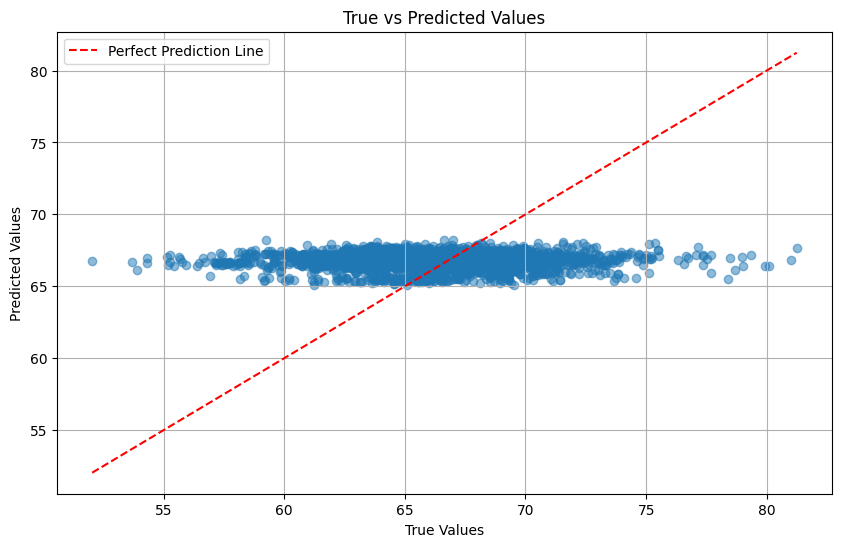

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred.detach().numpy(), alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')
plt.legend()
plt.grid(True)
plt.show()

# Cross validation

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
def cross_validation(
    X_continuous,
    X_categorical,
    y,
    categorical_vocab_size,
    embedding_size,
    hidden_size,
    output_size,
    num_epochs=100,
    batch_size=32,
    lr=0.001,
    n_splits=5
    ):
    kfold = KFold(n_splits=n_splits, shuffle=True)

    fold_losses = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_continuous)):
        X_train_continuous = X_continuous[train_idx]
        X_train_categorical = X_categorical[train_idx]
        y_train = y[train_idx]
        X_test_continuous = X_continuous[test_idx]
        X_test_categorical = X_categorical[test_idx]
        y_test = y[test_idx]

        train_dataset = TensorDataset(
            torch.tensor(X_train_continuous, dtype=torch.float32),
            torch.tensor(X_train_categorical, dtype=torch.long),
            torch.tensor(y_train, dtype=torch.float32)
        )
        test_dataset = TensorDataset(
            torch.tensor(X_test_continuous, dtype=torch.float32),
            torch.tensor(X_test_categorical, dtype=torch.long),
            torch.tensor(y_test, dtype=torch.float32)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        model = mix_model(X_train_continuous.shape[1], categorical_vocab_size, embedding_size, hidden_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            for X_batch_continuous, X_batch_categorical, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch_continuous, X_batch_categorical)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch_continuous, X_batch_categorical, y_batch in test_loader:
                outputs = model(X_batch_continuous, X_batch_categorical)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        fold_losses.append(avg_loss)
        print(f'Fold {fold + 1}, Test Loss: {avg_loss:.4f}')

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_splits + 1), fold_losses, marker='o', linestyle='-', color='b')
    plt.title('Cross-Validation Loss Per Fold')
    plt.xlabel('Fold Number')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    print(f'Average Loss across folds: {np.mean(fold_losses):.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Fold 1, Test Loss: 12.9186


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold 2, Test Loss: 12.4681
Fold 3, Test Loss: 12.8110
Fold 4, Test Loss: 13.1445
Fold 5, Test Loss: 14.1576


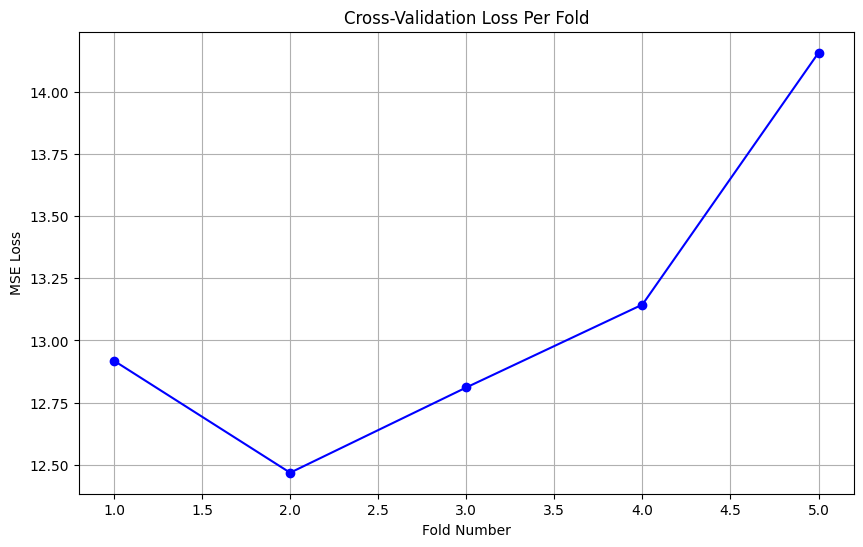

Average Loss across folds: 13.0999


In [ ]:
model_performance = cross_validation(
    X_train_continue,
    X_train_category,
    y,
    categorical_vocab_size,
    embedding_size=10,
    hidden_size=[128, 64],
    output_size=1,
    num_epochs=50,
    batch_size=64,
    lr=0.001,
    n_splits=5
)